# Explore the Vital Dynamics Mortality Components

In [1]:
import numpy as np

from laser.generic.newutils import grid
from laser.core import PropertySet
from laser.generic.newutils import ValuesMap
from laser.generic import Model
from laser.generic import SEIR
import laser.core.distributions as dists
from laser.core.demographics import AliasedDistribution
from laser.generic.vitaldynamics import MortalityByCDR

from laser.core import __version__ as laser_core_version
from laser.generic import __version__ as laser_generic_version
print(f"LASER version: {laser_core_version}")
print(f"LASER Generic version: {laser_generic_version}")


LASER version: 0.7.0
LASER Generic version: 0.0.0


In [2]:
ROWS = 1
COLS = 1
NNODES = ROWS * COLS
NTICKS = 3650
CDR = 20.0  # Crude Mortality Rate 20.0 per 1000 per year

scenario = grid(M=ROWS, N=COLS, population_fn=lambda i, j: 100_000)
# scenario["S"] = scenario.population
scenario["E"] = (scenario.population * 0.125).astype(np.int32)
scenario["I"] = (scenario.population * 0.125).astype(np.int32)
scenario["R"] = (scenario.population * 0.375).astype(np.int32)
scenario["S"] = (scenario.population - (scenario.E + scenario.I + scenario.R)).astype(np.int32)
parameters = PropertySet({"nticks": NTICKS})
mortalityrates = ValuesMap.from_scalar(CDR, NNODES, NTICKS).values

expdurdist = dists.normal(loc=30.0, scale=3.0)
infdurdist = dists.normal(loc=30.0, scale=5.0)


In [12]:
from datetime import datetime

parameters |= {"prng_seed": datetime.now().microsecond}
print(f"PRNG Seed: {parameters['prng_seed']}")
model = Model(scenario, parameters, birthrates=None)

model.components = [
    SEIR.Susceptible(model),
    SEIR.Exposed(model, expdurdist, infdurdist),
    SEIR.Infectious(model, infdurdist),
    SEIR.Recovered(model),
    # BirthsByCBR(model, birthrates, pyramid),
    MortalityByCDR(model, mortalityrates),
]

pop_start = model.people.count
print(f"At t=0    {model.people.count = :,}")
model.run()
pop_finish = model.people.count
print(f"At t={model.params.nticks} {model.people.count = :,}")


PRNG Seed: 142643
At t=0    model.people.count = 100,000


100,000 agents in 1 node(s): 100%|██████████| 3650/3650 [00:01<00:00, 2258.60it/s]

At t=3650 model.people.count = 100,000


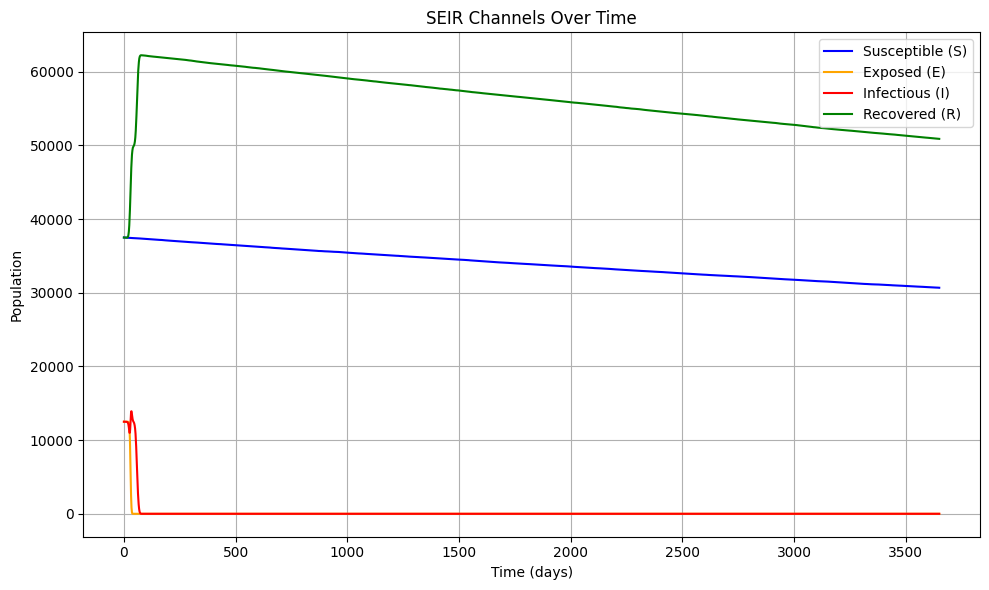

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(model.nodes.S[:,0], label="Susceptible (S)", color="blue")
plt.plot(model.nodes.E[:,0], label="Exposed (E)", color="orange")
plt.plot(model.nodes.I[:,0], label="Infectious (I)", color="red")
plt.plot(model.nodes.R[:,0], label="Recovered (R)", color="green")
plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.title("SEIR Channels Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
from laser.generic.shared import State

print(f"{(model.people.state != State.DECEASED.value).sum() = :,}")
print(f"{(model.nodes.S + model.nodes.E + model.nodes.I + model.nodes.R)[-1] =}")
N = model.nodes.S + model.nodes.E + model.nodes.I + model.nodes.R
starts = np.array(range(0, NTICKS, 365), dtype=np.int32)
ends = starts + 364
mortality = (1000 * (N[starts] - N[ends]) / N[starts]).mean(axis=0)[0]
# print(f"{mortality.shape = }")
print(f"{mortality = }")

(model.people.state != State.DECEASED.value).sum() = 81,569
(model.nodes.S + model.nodes.E + model.nodes.I + model.nodes.R)[-1] =array([81569], dtype=int32)
mortality = np.float64(20.095424016786428)


## Test

Let's run the model several times over different CDR values and plot the results.

We'll run 11 times each with 100_000 population and CDR values in [2, 10, 20, 40] and plot the histogram of CDR and mean for each CDR.

CDR 40 Run 11/11: 100%|██████████| 3650/3650 [00:01<00:00, 2284.84it/s]


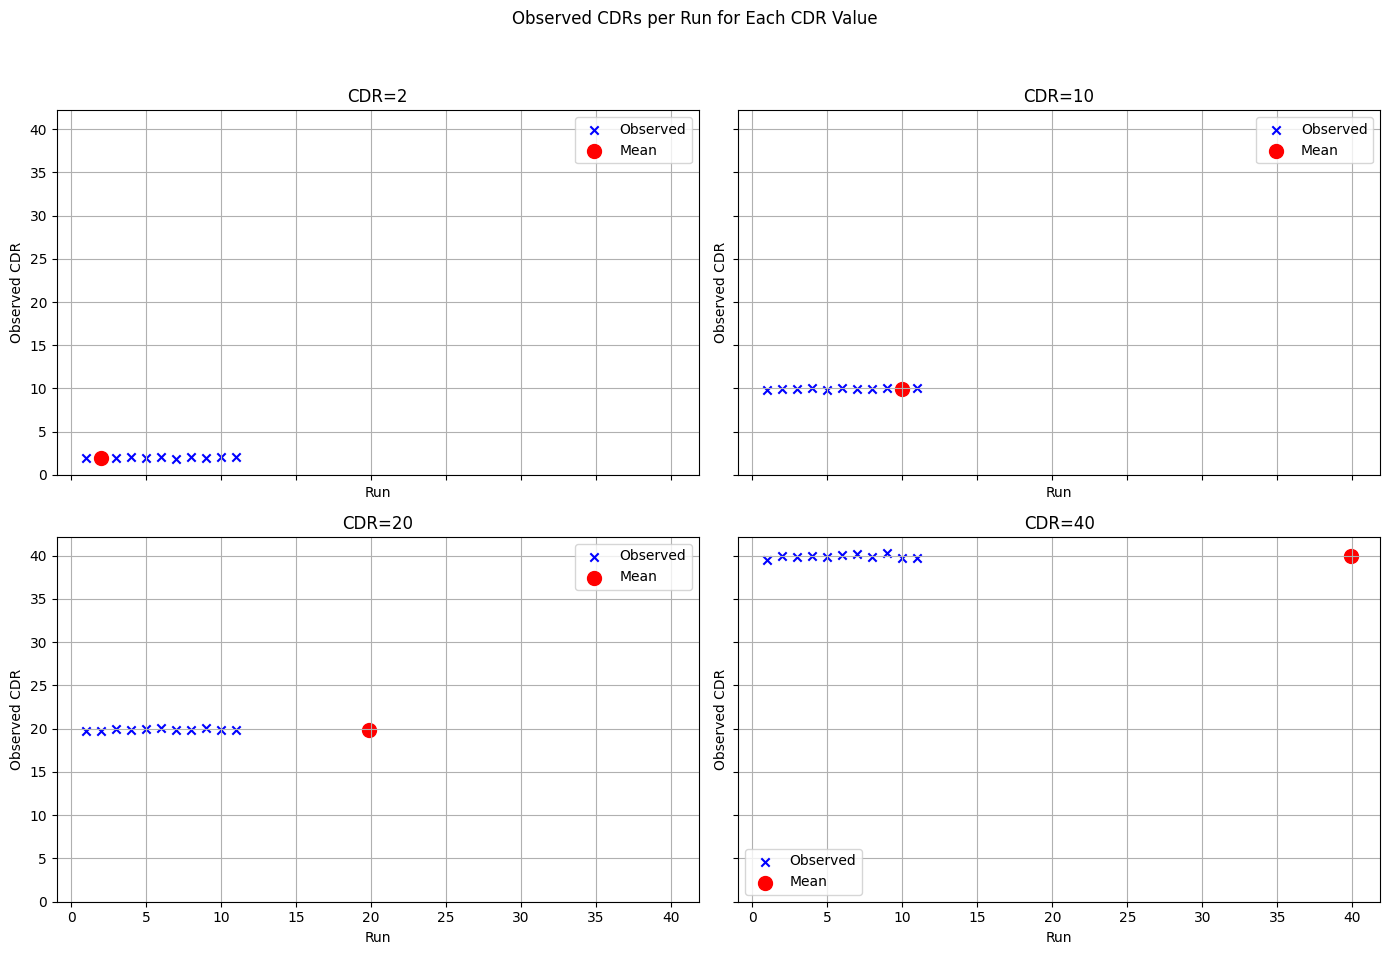

In [ ]:
cdr_values = [2, 10, 20, 40]
n_runs = 11
results = {}

for cdr in cdr_values:
    run_mortalities = []
    for index in range(n_runs):
        # Set up scenario and parameters for each run
        scenario = grid(M=ROWS, N=COLS, population_fn=lambda i, j: 100_000)
        scenario["E"] = (scenario.population * 0.125).astype(np.int32)
        scenario["I"] = (scenario.population * 0.125).astype(np.int32)
        scenario["R"] = (scenario.population * 0.375).astype(np.int32)
        scenario["S"] = (scenario.population - (scenario.E + scenario.I + scenario.R)).astype(np.int32)
        parameters_run = PropertySet({"nticks": NTICKS, "prng_seed": np.random.randint(0, 1_000_000)})
        mortalityrates_run = ValuesMap.from_scalar(cdr, NNODES, NTICKS).values

        model_run = Model(scenario, parameters_run, birthrates=None)
        model_run.components = [
            SEIR.Susceptible(model_run),
            SEIR.Exposed(model_run, expdurdist, infdurdist),
            SEIR.Infectious(model_run, infdurdist),
            SEIR.Recovered(model_run),
            MortalityByCDR(model_run, mortalityrates_run),
        ]
        model_run.run(f"CDR {cdr:2} Run {index+1:02}/{n_runs:02}")
        N_run = model_run.nodes.S + model_run.nodes.E + model_run.nodes.I + model_run.nodes.R
        starts_run = np.array(range(0, NTICKS, 365), dtype=np.int32)
        ends_run = starts_run + 364
        mortality_run = (1000 * (N_run[starts_run] - N_run[ends_run]) / N_run[starts_run]).mean(axis=0)[0]
        run_mortalities.append(mortality_run)
    results[cdr] = run_mortalities



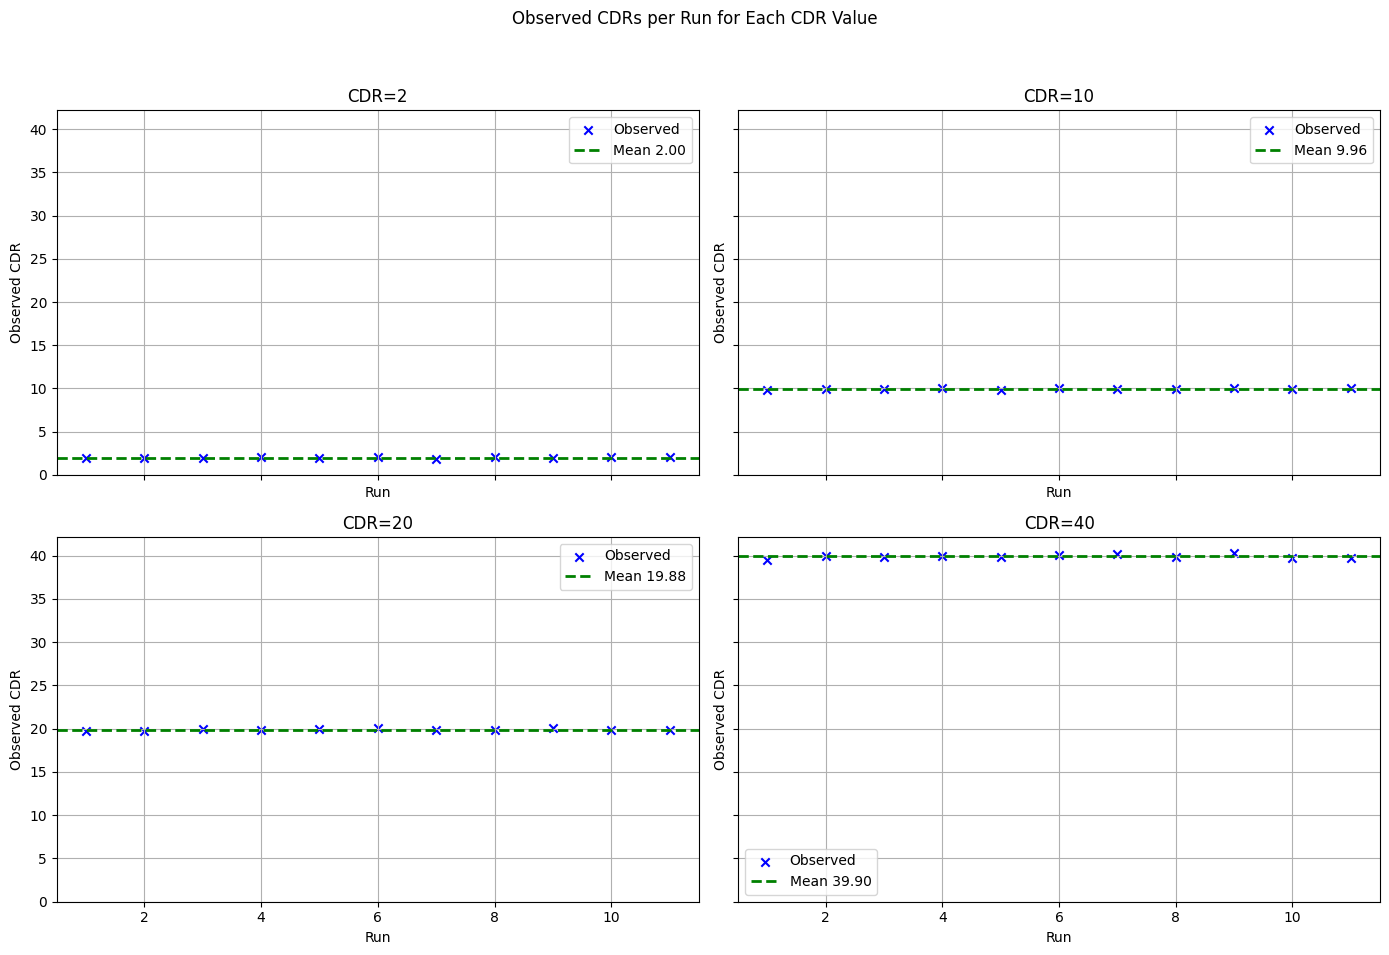

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
axes = axes.flatten()

for idx, cdr in enumerate(cdr_values):
    ax = axes[idx]
    mortalities = results[cdr]
    ax.scatter(range(1, n_runs + 1), mortalities, color="blue", marker="x", label="Observed")
    ax.axhline(np.mean(mortalities), color="green", linestyle="--", linewidth=2, label=f"Mean {np.mean(mortalities):.2f}")
    ax.set_title(f"CDR={cdr}")
    ax.set_xlabel("Run")
    ax.set_ylabel("Observed CDR")
    ax.grid(True)
    ax.legend()

plt.suptitle("Observed CDRs per Run for Each CDR Value")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()